In [1]:
# instalamos librería pca
!pip install -q pca
!pip install --upgrade plotly --q

# Tratamiento de datos
# ==============================================================================
import pandas as pd
from pandas.plotting import table
import numpy as np
import statsmodels.api as sm
import sklearn
import six
import ftplib
import os
import math

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.dates import date2num, num2date
import seaborn as sns
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib import animation
plt.style.use("ggplot")# for pretty graphs
from IPython.display import clear_output
import plotly.express as px

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.cluster import k_means
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# Configuración warnings
# ==============================================================================
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd

     |████████████████████████████████| 13.2MB 253kB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Instalar Librería para leer el objeto R
!pip install pyreadr --q

     |████████████████████████████████| 419kB 5.1MB/s 


In [3]:
import pyreadr # librería para leer archivos generados con R
from urllib.request import urlopen # Necesario para leer el archivo RData con información Covid

In [4]:
import pyreadr # librería para leer archivos generados con R
from urllib.request import urlopen # Necesario para leer el archivo RData con información Covid

#Leemos el archivo RData de datos Covid-19 desde el Github de Ruben F. Casal
url="https://github.com/rubenfcasal/COVID-19/blob/master/acumula2.RData?raw=true"
archivo = urlopen(url)
contenido = archivo.read()
fhandle = open('acumula2.RData', 'wb')
fhandle.write(contenido)
fhandle.close()
resultado = pyreadr.read_r("acumula2.RData")

# Convertimos el archivo R a Dataframe Pandas
print(resultado.keys()) # Validamos los objetos que obtenemos de los datos R que serán la base del DataFrame
df_covid = resultado["acumula2"] # Extracción de la información del objeto R hacia Pandas DataFrame
type(df_covid) # Validamos el dipo de objeto generado para confirmar que tenemos nuestro PD DataFrame

df_covid.head(200)

odict_keys(['acumula2'])


,fecha,iso,ccaa,confirmados,hospitalizados,uci,fallecidos
0,2020-01-01,ES,España,0,8,0,0
1,2020-01-01,AN,Andalucía,0,3,0,0
2,2020-01-01,AR,Aragón,0,0,0,0
3,2020-01-01,AS,Asturias,0,0,0,0
4,2020-01-01,CN,Canarias,0,0,0,0
...,...,...,...,...,...,...,...
195,2020-01-10,MD,Madrid,0,31,2,0
196,2020-01-10,MC,Murcia,0,1,0,0
197,2020-01-10,NC,Navarra,0,0,0,0
198,2020-01-10,PV,País Vasco,0,4,1,0


In [5]:
# abro mis datos

url1='https://raw.githubusercontent.com/TFM-BigData-COVID19/BUILDING_DATABASE/main/datos_covid_v4.csv'
df1=pd.read_csv(url1, sep=';', decimal=',')
#informacion de las variables
#print(df1.info())
df1.head(4) 
#df1.columns
#df1.ISO.unique()

,CCAA,ISO,VIH,Diabetes,trastornos mentales,asma,EPOC,obesidad,tasa_pobreza,nivel_estudios,social,camas_funcionamiento,hospital_dia_funcionamiento,gasto_sanitario,infeccion_hospitalaria,frecuentacion_hospitalizacion,Densidad Poblacional (hab/km2),Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental,Infectados1M(2020),Infectados1M(2021),Hospitalizados1M(2020),Hospitalizados1M(2021),UCI1M(2020),UCI1M(2021),fallecidos1M(2020),fallecidos1M(2021),Vacunados_completos_%
0,Andalucía,AN,7.27,8.25,12.00,4.93,3.42,37.53,32.0,49.0,52.08,77.03,86.98,1264.66,1.33,69.18,96.02,42.48,17.41,8.25,51.61,26.50,8.35,8.66,81.94,20.25,26.50,0.264340,0.318018,0.023783,0.023160,0.002486,0.002776,0.005209,0.004631,7.2
1,Aragón,AR,8.51,7.90,8.62,3.86,4.29,36.80,14.2,35.5,46.57,85.10,86.14,1620.35,1.12,83.99,27.43,45.12,21.73,11.44,58.07,12.54,10.28,10.72,83.71,21.65,12.54,0.079531,0.043616,0.008991,0.003937,0.000828,0.000431,0.002612,0.000876,7.9
2,Asturias,AS,5.27,8.66,18.68,5.71,4.68,37.44,14.0,33.2,51.89,85.91,92.80,1683.67,0.76,89.14,97.60,48.87,26.09,13.04,58.65,17.23,12.64,12.93,82.80,21.17,17.23,0.027278,0.025220,0.005036,0.003512,0.000401,0.000355,0.001374,0.000593,9.7
3,Canarias,CN,12.43,10.99,9.66,3.81,1.71,37.20,32.1,44.6,52.15,68.82,86.68,1530.02,1.60,59.07,283.08,43.09,16.54,7.50,43.84,14.33,7.10,7.45,82.53,21.02,14.33,0.026550,0.028850,0.003088,0.002226,0.000561,0.000548,0.000428,0.000332,5.6


In [6]:
# Junto las dos tablas
df2 = pd.merge(df_covid, df1, left_on='iso', right_on='ISO')
#df2.head(30)
df2.info()
df2.iso.unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9468 entries, 0 to 9467
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   fecha                           9468 non-null   object  
 1   iso                             9468 non-null   object  
 2   ccaa                            9468 non-null   category
 3   confirmados                     9468 non-null   int32   
 4   hospitalizados                  9468 non-null   int32   
 5   uci                             9468 non-null   int32   
 6   fallecidos                      9468 non-null   int32   
 7   CCAA                            9468 non-null   object  
 8   ISO                             9468 non-null   object  
 9   VIH                             9468 non-null   float64 
 10  Diabetes                        9468 non-null   float64 
 11  trastornos mentales             9468 non-null   float64 
 12  asma                

array(['AN', 'AR', 'AS', 'CN', 'CB', 'CL', 'CM', 'CT', 'EA', 'VC', 'EX',
       'GA', 'IB', 'RI', 'MD', 'MC', 'NC', 'PV'], dtype=object)

# DATOS DEMOGRAFICOS

In [7]:
# ANALISIS DE LOS DATOS DEMOGRAFICOS

# selecciono las columnas que tocan

#datos_demograficos = df2[['fecha','ccaa','confirmados','hospitalizados','fallecidos','uci','Edad Media (años)','Mayores 65 años (%)','Mayores 75 años(%)', 'Índice de dependencia', 'Tasa de Mortalidad (2017)', 'Tasa de Mortalidad (2018)', 'Tasa de Mortalidad (2019)', 'Esperanza_nascer','Esperanza_65años','Mala_salud_mental', 'Vacunados_completos_%'  ] ]
#datos_demograficos

datos_demograficos_solos = df2[['Edad Media (años)','Mayores 65 años (%)','Mayores 75 años(%)', 'Índice de dependencia', 'Tasa de Mortalidad (2017)', 'Tasa de Mortalidad (2018)', 'Tasa de Mortalidad (2019)', 'Esperanza_nascer','Esperanza_65años','Mala_salud_mental'] ]
datos_demograficos_solos

datos_demograficos_solos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9468 entries, 0 to 9467
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Edad Media (años)          9468 non-null   float64
 1   Mayores 65 años (%)        9468 non-null   float64
 2   Mayores 75 años(%)         9468 non-null   float64
 3   Índice de dependencia      9468 non-null   float64
 4   Tasa de Mortalidad (2017)  9468 non-null   float64
 5   Tasa de Mortalidad (2018)  9468 non-null   float64
 6   Tasa de Mortalidad (2019)  9468 non-null   float64
 7   Esperanza_nascer           9468 non-null   float64
 8   Esperanza_65años           9468 non-null   float64
 9   Mala_salud_mental          9468 non-null   float64
dtypes: float64(10)
memory usage: 813.7 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f222bc44490>,
      dtype=object)

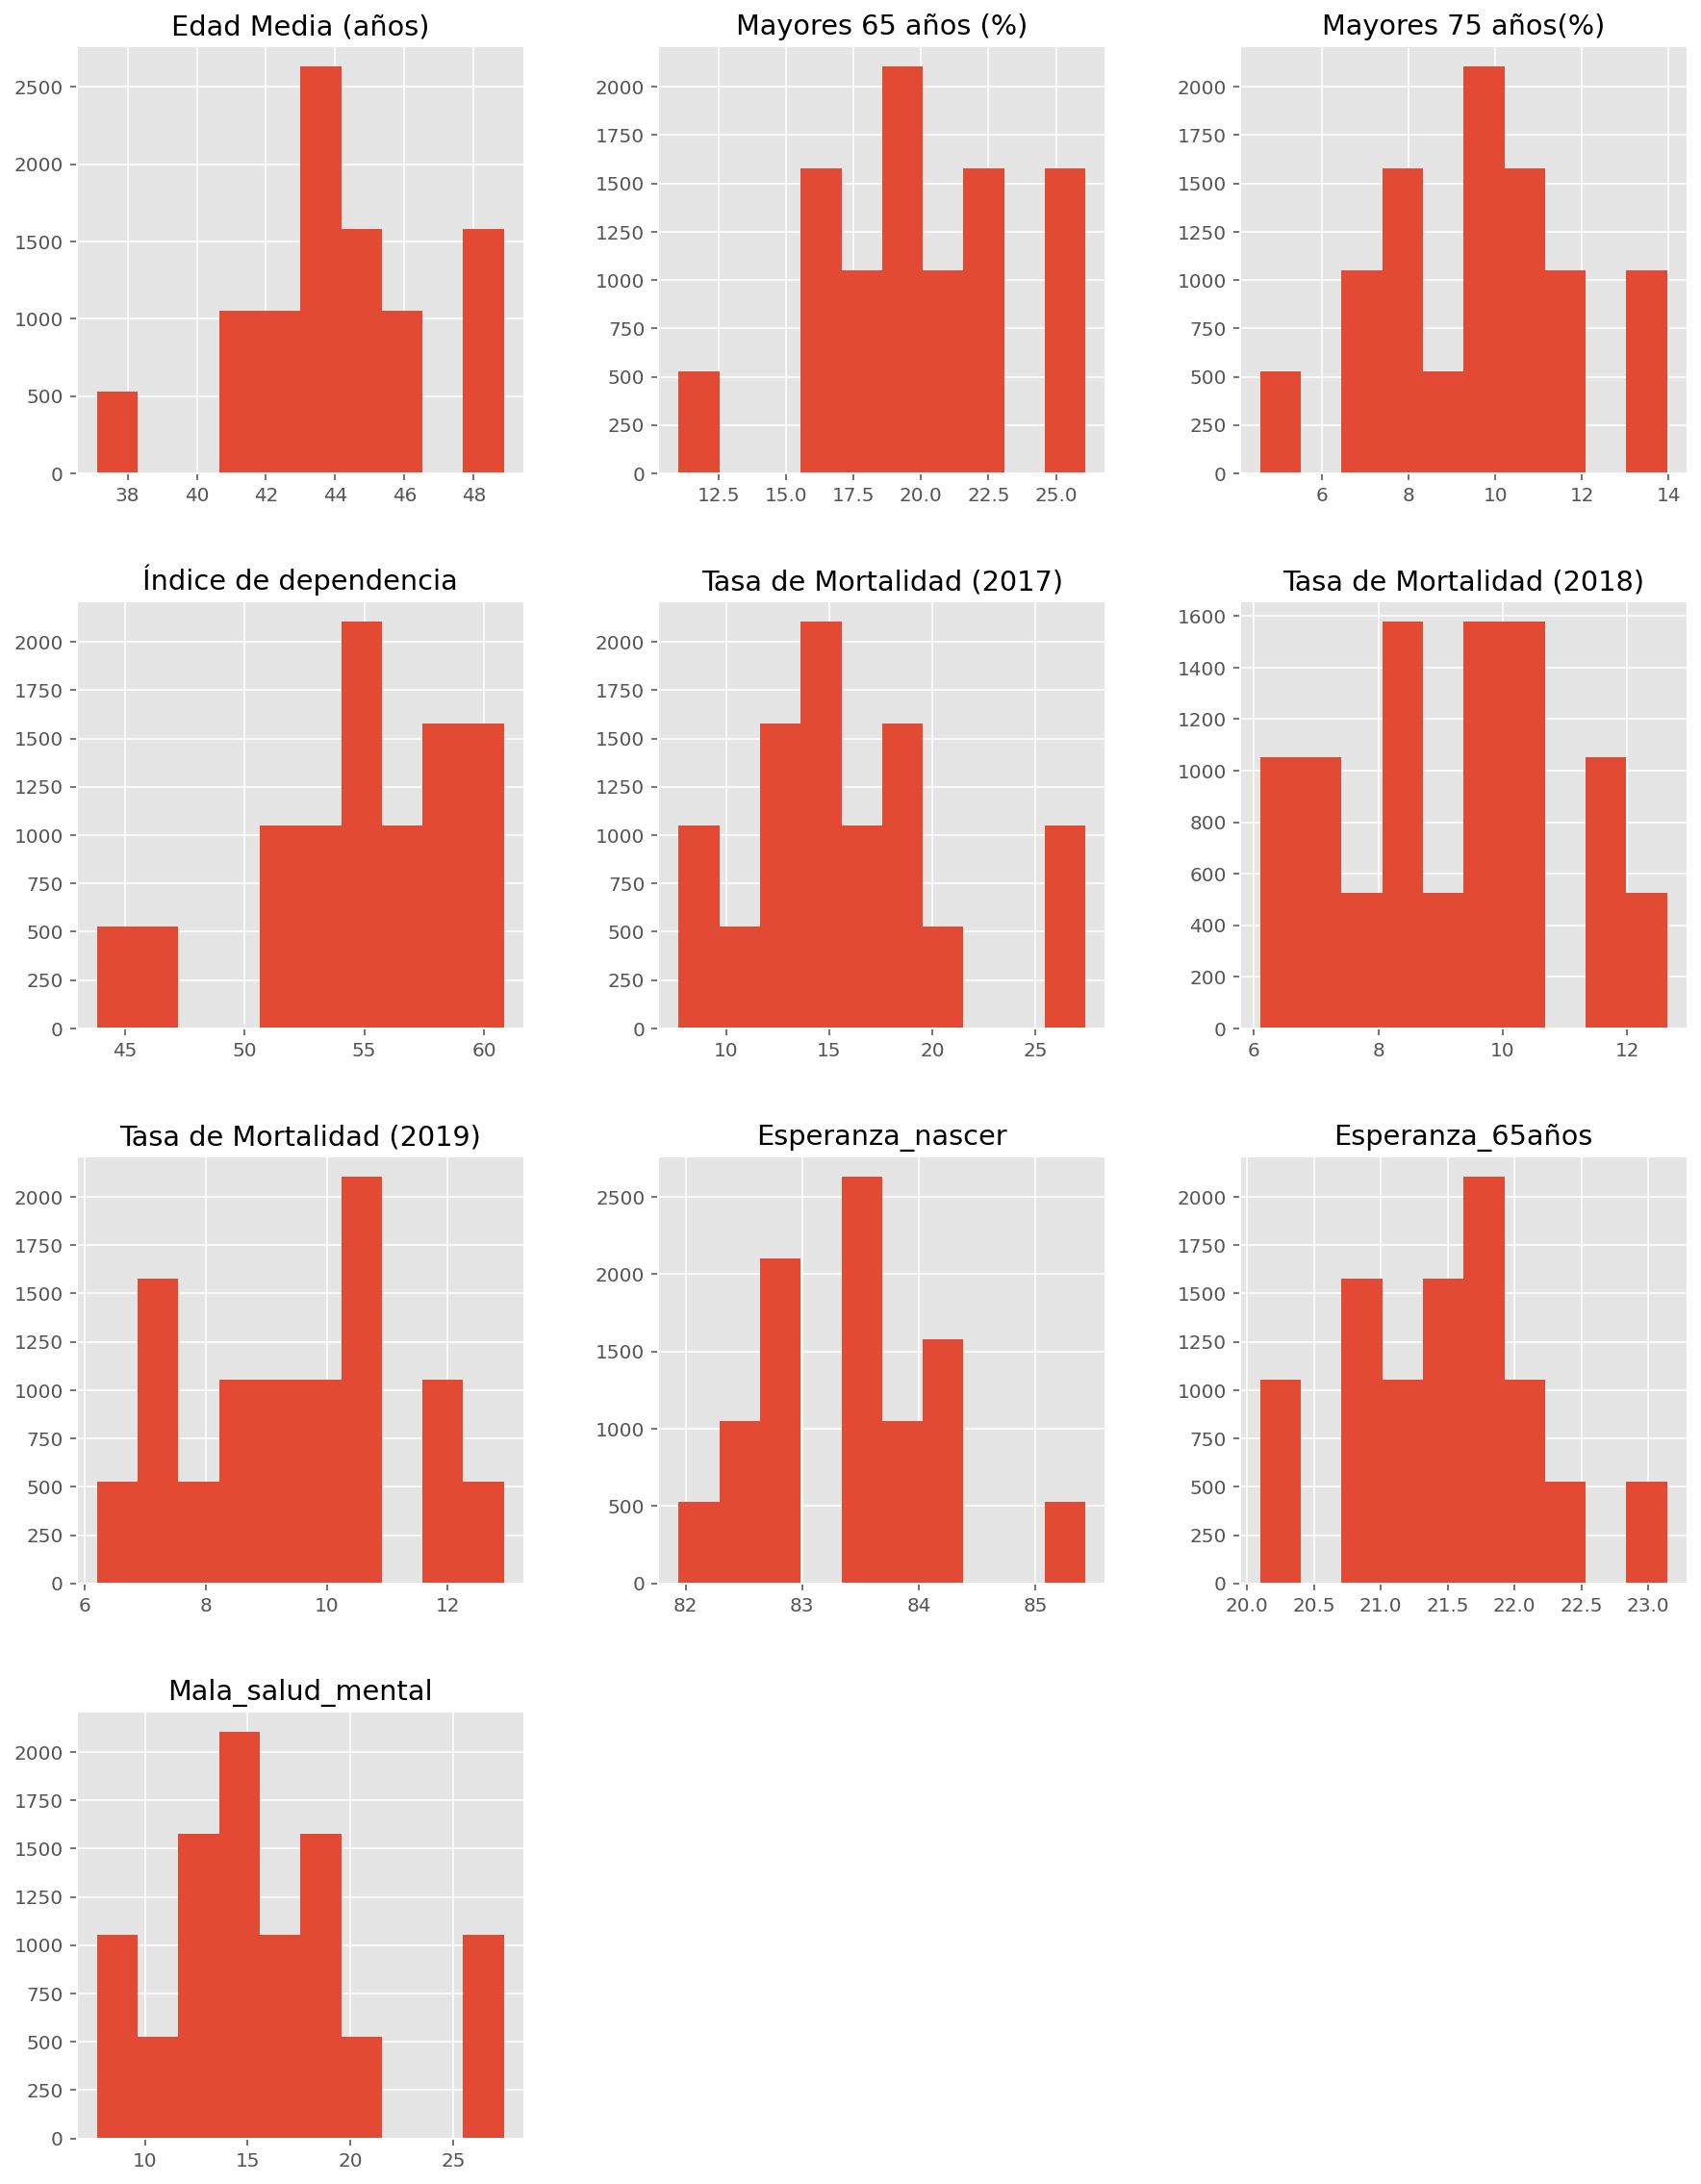

In [10]:
# para los histogramas: https://colab.research.google.com/notebooks/charts.ipynb
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
datos_demograficos_solos.hist(ax = ax)

In [ ]:
datos_demograficos_solos.describe().T

,count,mean,std,min,25%,50%,75%,max
Edad Media (años),9468.0,44.077778,2.705946,37.12,42.72,43.665,45.79,48.87
Mayores 65 años (%),9468.0,19.933889,3.753641,11.03,17.41,19.815,22.29,26.09
Mayores 75 años(%),9468.0,9.646667,2.242466,4.57,7.62,9.785,11.03,13.96
Índice de dependencia,9468.0,54.832222,4.402634,43.84,52.47,55.200,58.07,60.82
Tasa de Mortalidad (2017),9468.0,15.975556,5.167249,7.68,12.20,14.900,18.92,27.45
Tasa de Mortalidad (2018),9468.0,9.202778,1.822445,6.10,7.74,9.175,10.33,12.64
Tasa de Mortalidad (2019),9468.0,9.443889,1.857052,6.20,7.66,9.400,10.72,12.93
Esperanza_nascer,9468.0,83.400000,0.825964,81.94,82.79,83.535,83.81,85.43
Esperanza_65años,9468.0,21.440556,0.707313,20.10,20.97,21.530,21.69,23.14
Mala_salud_mental,9468.0,15.992222,5.162622,7.68,12.20,15.050,18.92,27.45


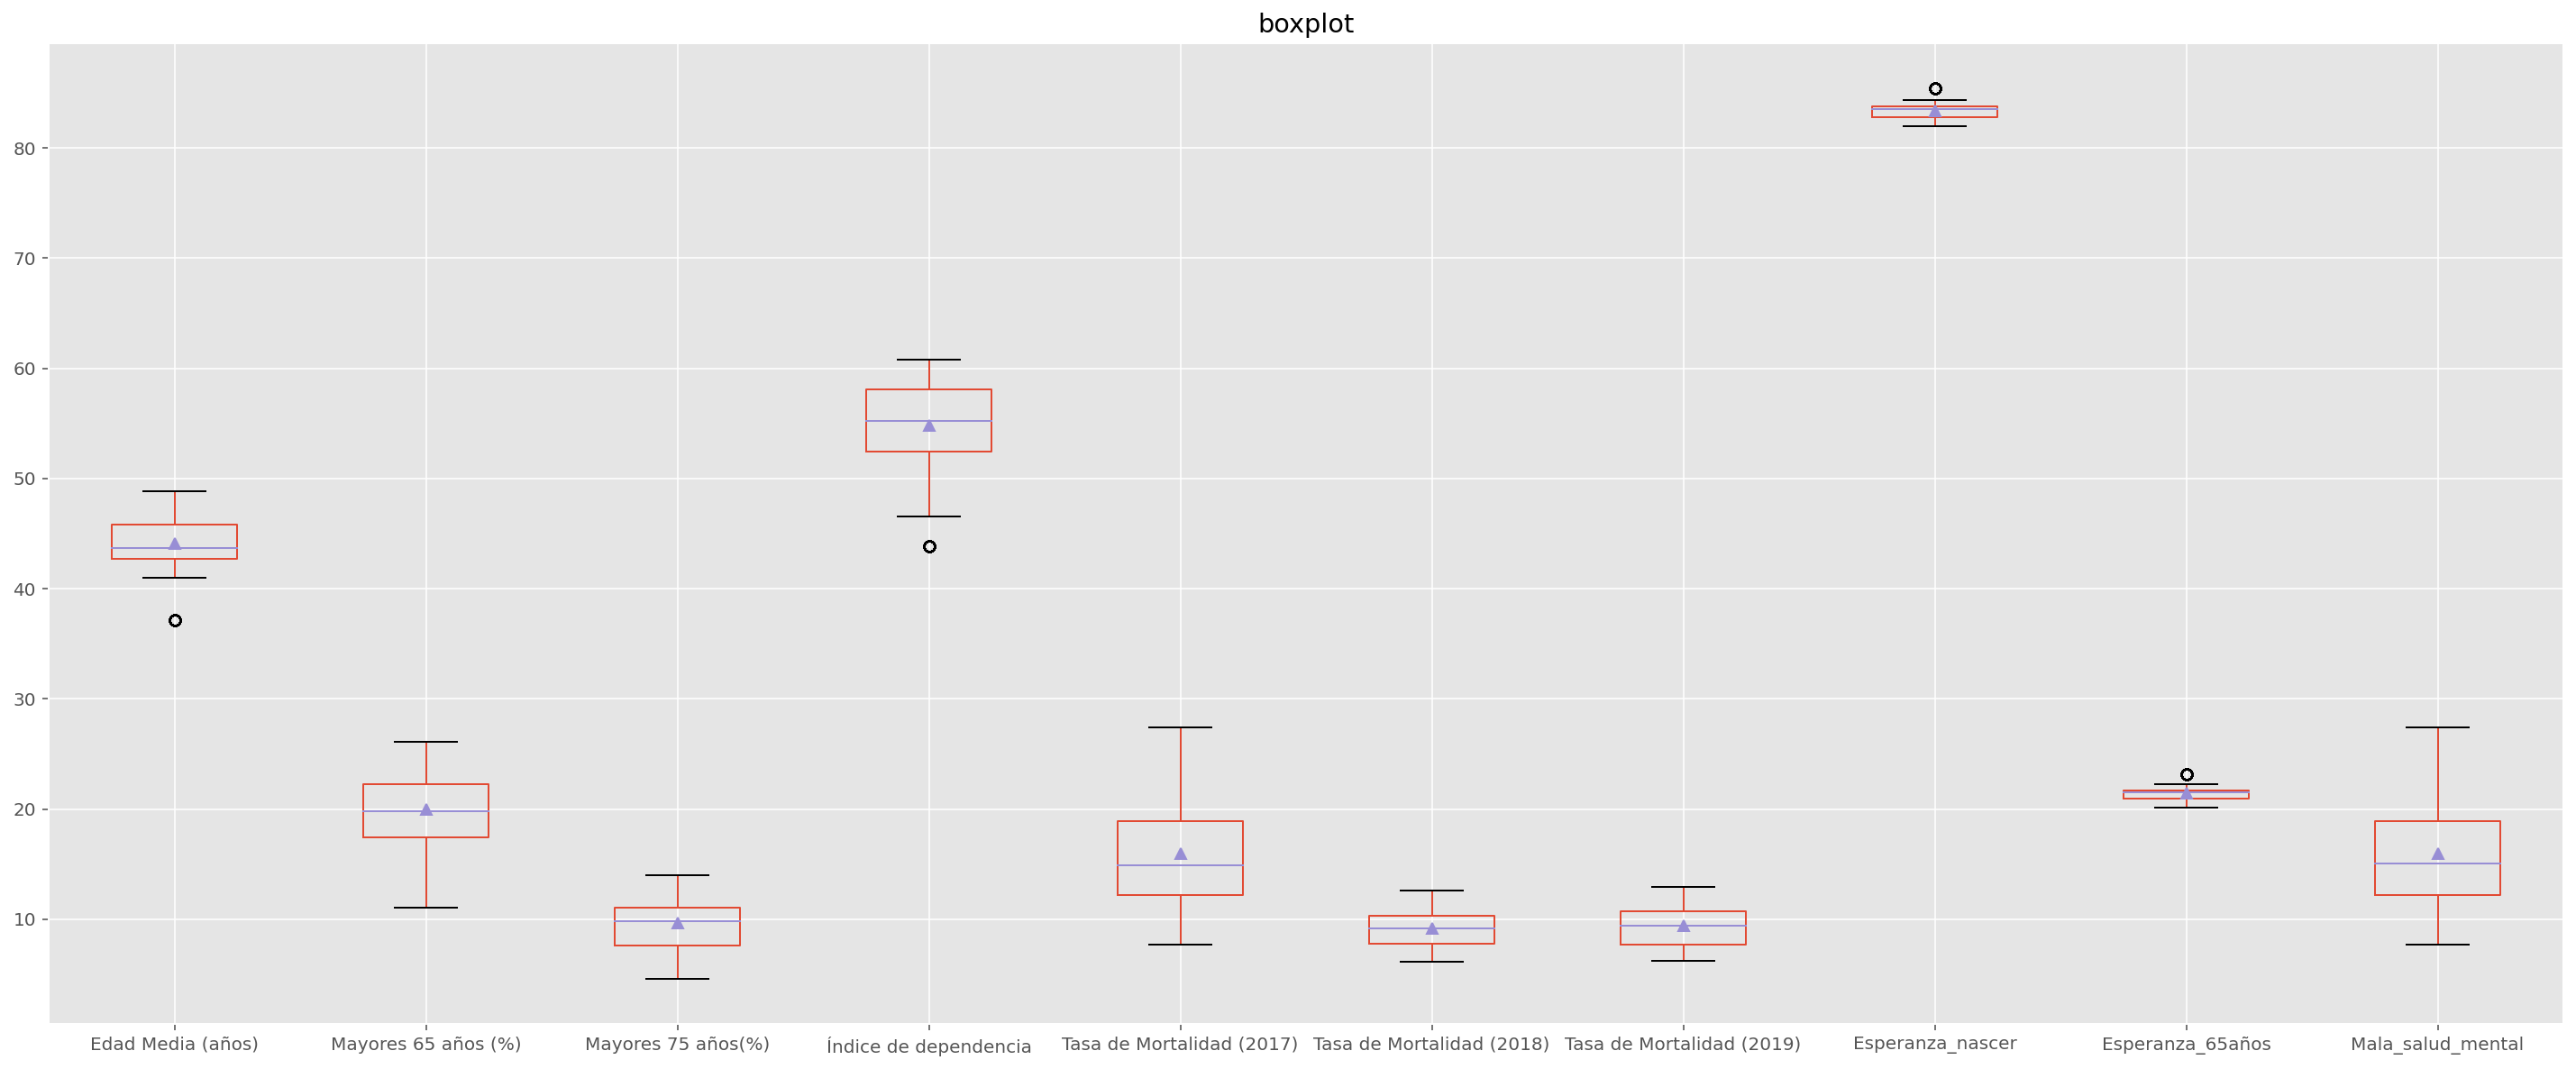

In [ ]:
ax= datos_demograficos_solos.plot(kind='box', title='boxplot', showmeans=True, figsize=(25, 10))
plt.show()

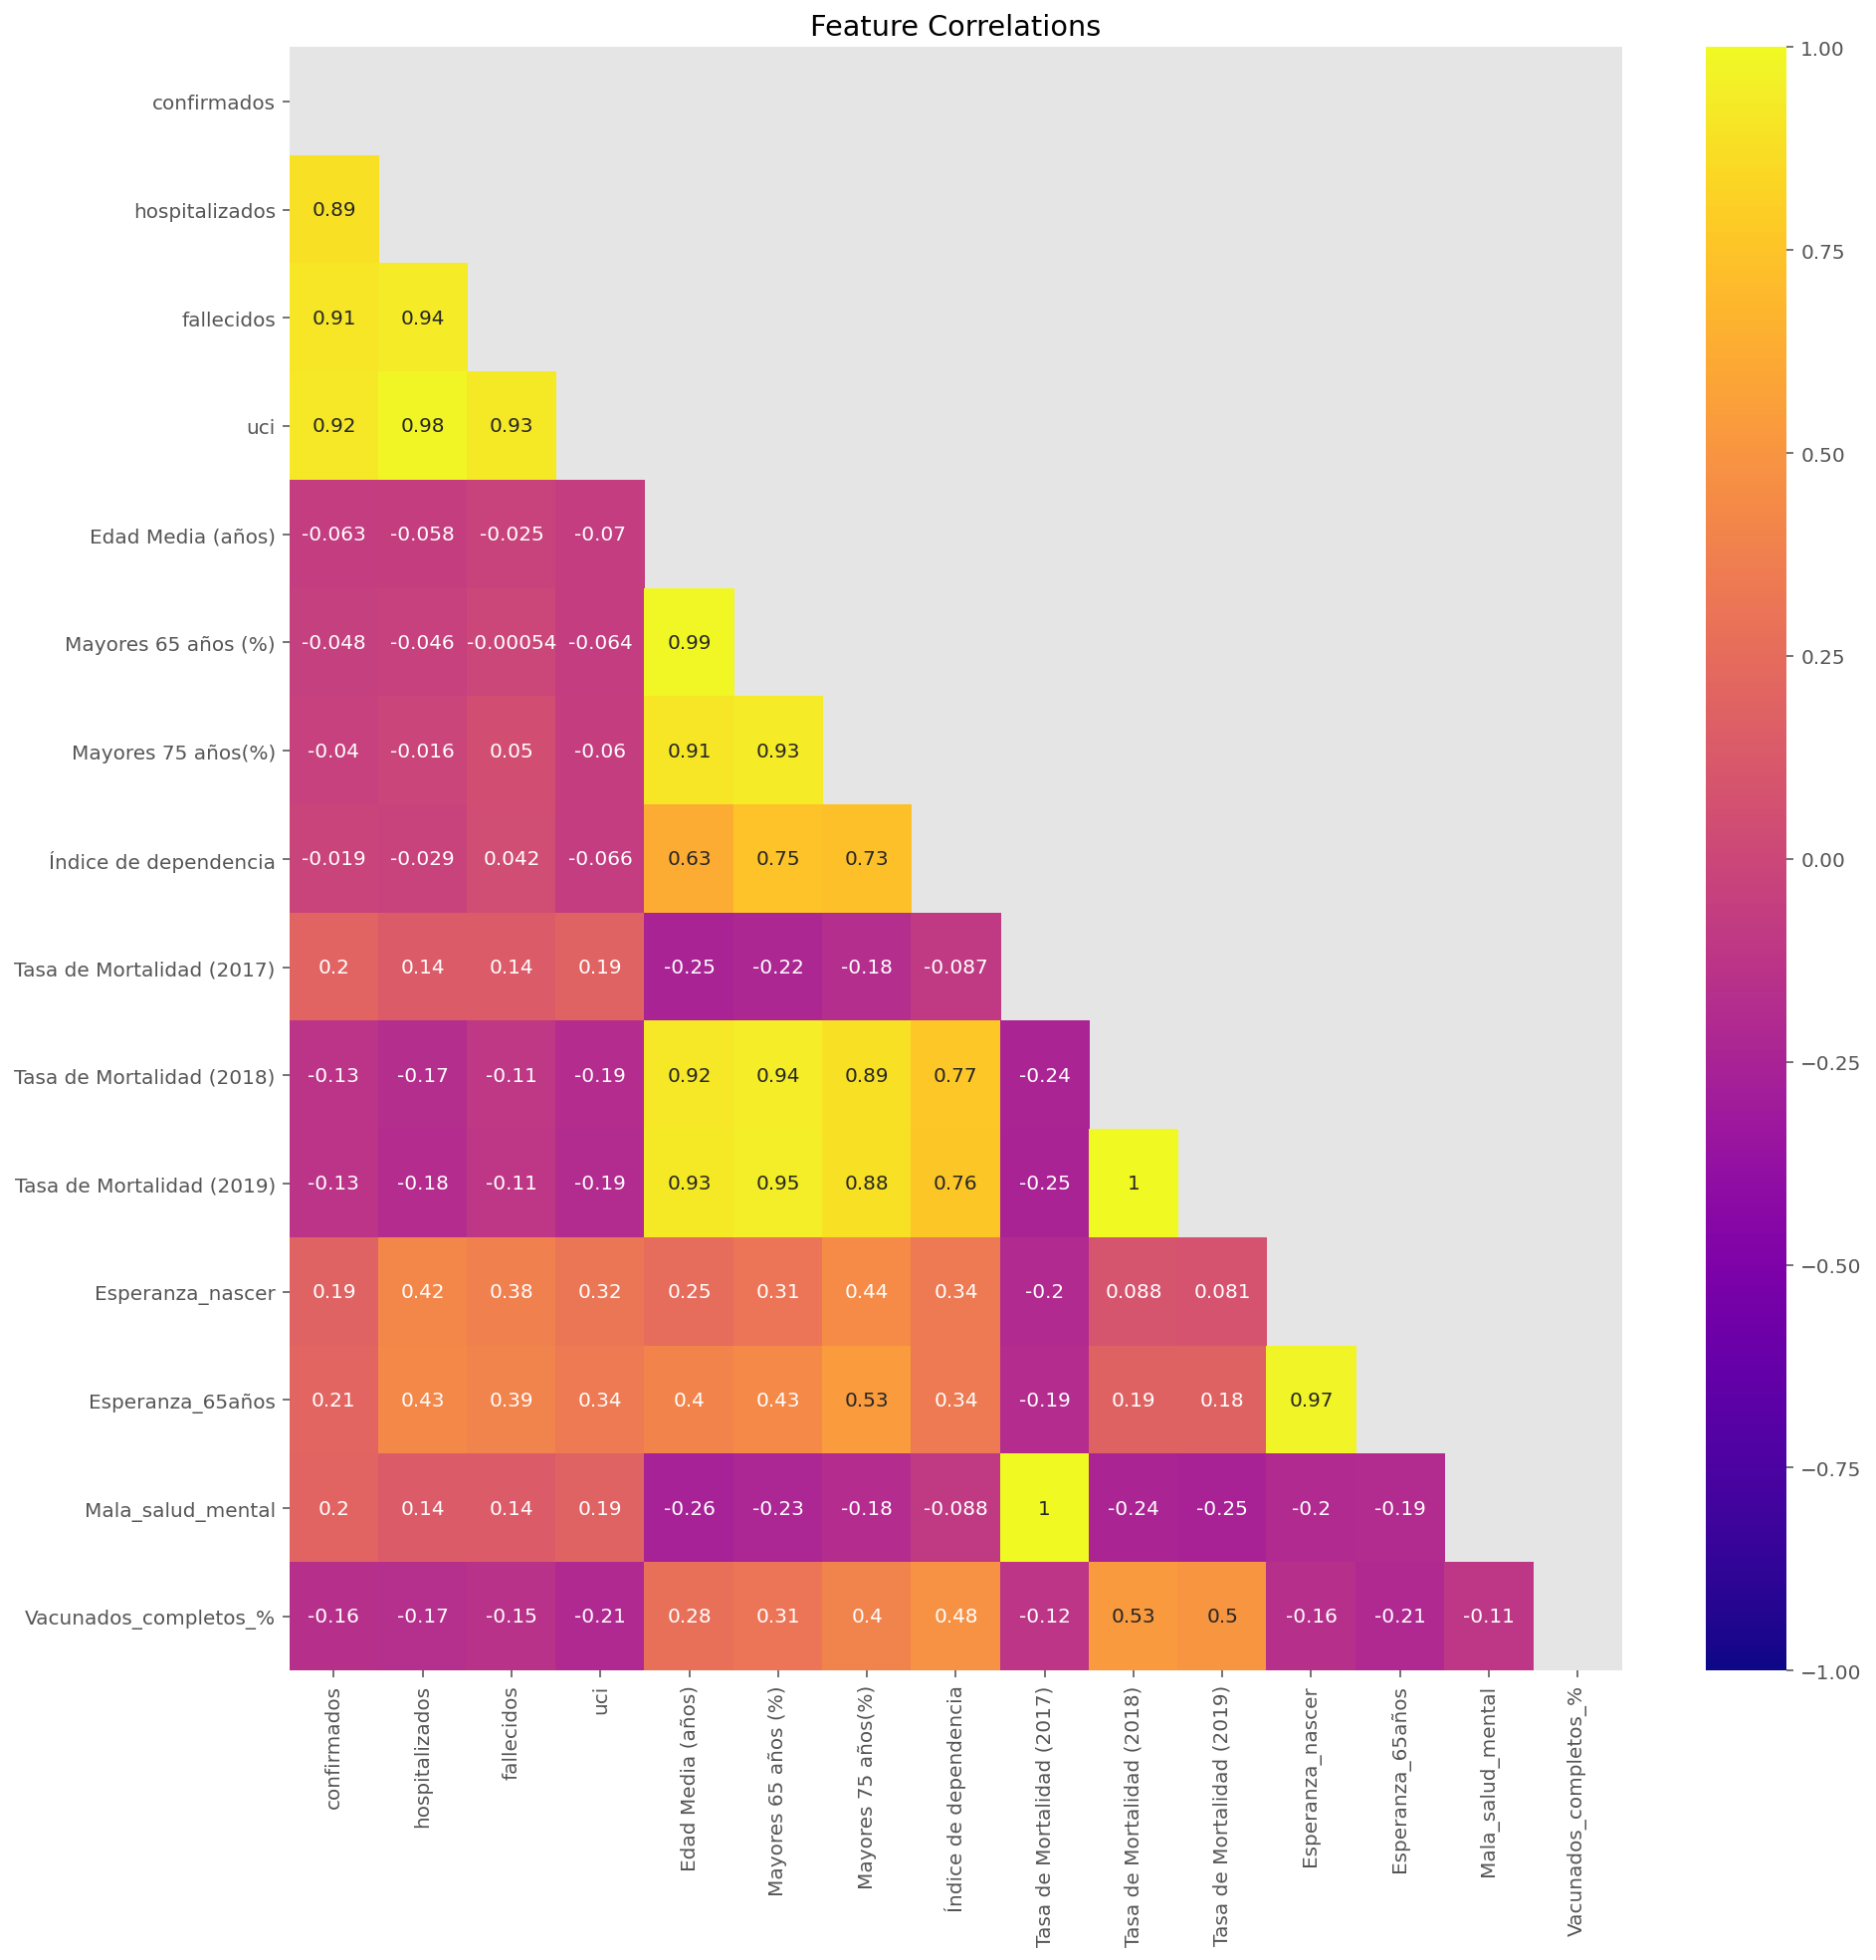

In [ ]:
colormap = plt.cm.plasma
matrix1 = np.triu(datos_demograficos.corr())
plt.figure(figsize=(15, 15))
sns.heatmap(datos_demograficos.corr(), annot=True, vmax=1, vmin=-1, mask=matrix1, cmap=colormap)
plt.title("Feature Correlations")
plt.show()

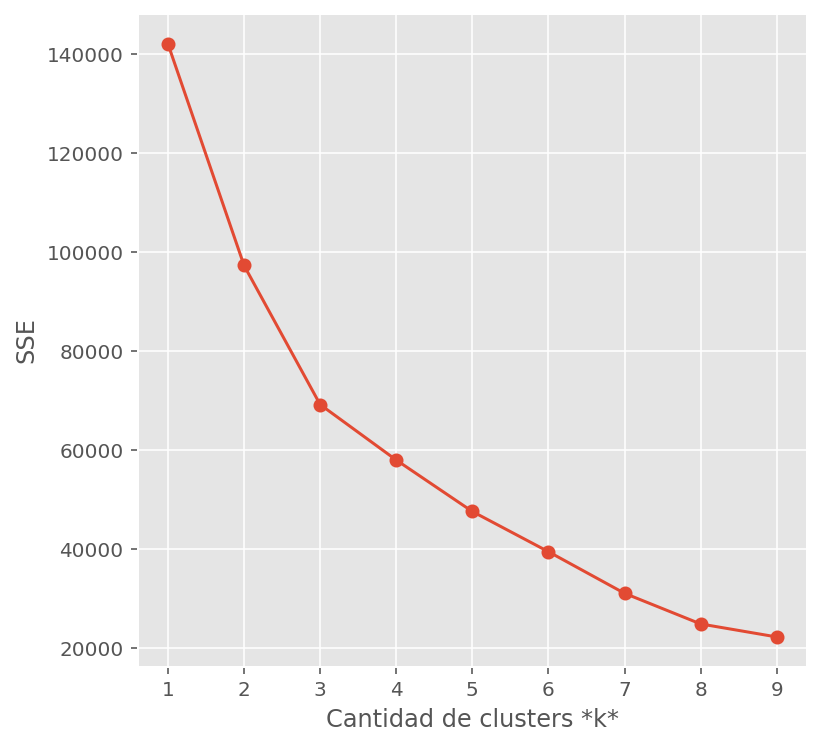

In [ ]:
# HAGO EL CLUSTER PARA LOS INFECTADOS,

# cambio el nombre de la columna
datos_demograficos = datos_demograficos.rename(columns={'Unnamed: 0':'ccaa'})
datos_demograficos.columns
datos_demograficos.head(5)

# elimino la columna de NA
df2 = datos_demograficos.drop(['ccaa', 'fecha'], axis=1) # hago el analisis sin el 
df2.head(5)
# scale
scaled_1 = scale(df2)

# Corro el algoritmo con K entre 2 y 10 y voy guardando el error para luego graficarlo.
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(scaled_1)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters *k*')
plt.ylabel('SSE');



In [ ]:
# ajustado el algoritmo Kmeans ak conjunto de datos. Elijo 4 clústers
from sklearn.cluster import KMeans

## Numero de clústers a utilizar. En este caso 4 clústers
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(df2)
y_kmeans1=y_kmeans+1
cluster = pd.DataFrame(y_kmeans1)
today_sub=df2
# Adding cluster to the Dataset
today_sub['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(today_sub.groupby('cluster').mean(),1))

## Identificación de los valores promedio (centroides) 
kmeans_mean_cluster

,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental,Vacunados_completos_%
cluster,,,,,,,,,,,,,,,
1,10660.5,2366.6,569.9,237.0,44.0,19.8,9.6,54.7,15.3,9.2,9.5,83.3,21.3,15.4,7.4
2,580330.1,61946.8,13009.5,5142.8,42.8,18.2,8.9,53.3,18.7,7.9,8.1,83.9,21.9,18.7,6.6
3,193830.8,22635.0,5686.6,1864.6,44.9,21.2,10.8,56.7,18.2,9.7,9.9,83.8,21.8,18.2,7.2
4,380195.6,42395.3,9074.8,3602.5,43.2,18.8,8.4,53.9,19.4,8.2,8.5,83.5,21.6,19.4,6.3
5,79617.2,12040.7,2879.6,1131.7,44.3,20.4,9.9,55.2,16.1,9.3,9.6,83.6,21.6,16.1,6.9


In [ ]:
today_Sub_2=pd.concat([datos_demograficos[['ccaa']],df2],axis=1)
today_Sub_2.head(10)

,ccaa,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental,Vacunados_completos_%,cluster
0,Andalucía,0,3,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5,7.2,1
1,Andalucía,0,8,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5,7.2,1
2,Andalucía,0,10,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5,7.2,1
3,Andalucía,0,11,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5,7.2,1
4,Andalucía,0,13,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5,7.2,1
5,Andalucía,0,14,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5,7.2,1
6,Andalucía,0,15,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5,7.2,1
7,Andalucía,0,15,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5,7.2,1
8,Andalucía,0,15,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5,7.2,1
9,Andalucía,0,15,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5,7.2,1


In [ ]:
for i in range(1,5):
    print('****Comunidades autónomas en el grupo {}*****'.format(str(i)))
    print(list(today_Sub_2[today_Sub_2.cluster==i]['ccaa'].values))

****Comunidades autónomas en el grupo 1*****
['Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Andalucía', 'Anda

In [ ]:
import plotly
import plotly.express as px


In [ ]:
#import plotly.express as px
fig = px.treemap(today_Sub_2, path=['cluster','ccaa'], values='confirmados')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

In [ ]:

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# División de los datos en train y test
# ==============================================================================
#df2 = df1.drop(['ccaa'], axis = 1)

df3 = datos_demograficos.drop(['ccaa', 'confirmados', 'fecha'], axis=1) # hag
X = df3
y = datos_demograficos['confirmados'] # infectados totales

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     5734.
Date:                Sun, 13 Jun 2021   Prob (F-statistic):               0.00
Time:                        15:58:59   Log-Likelihood:                -90731.
No. Observations:                7574   AIC:                         1.815e+05
Df Residuals:                    7559   BIC:                         1.816e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

ValueError: ignored

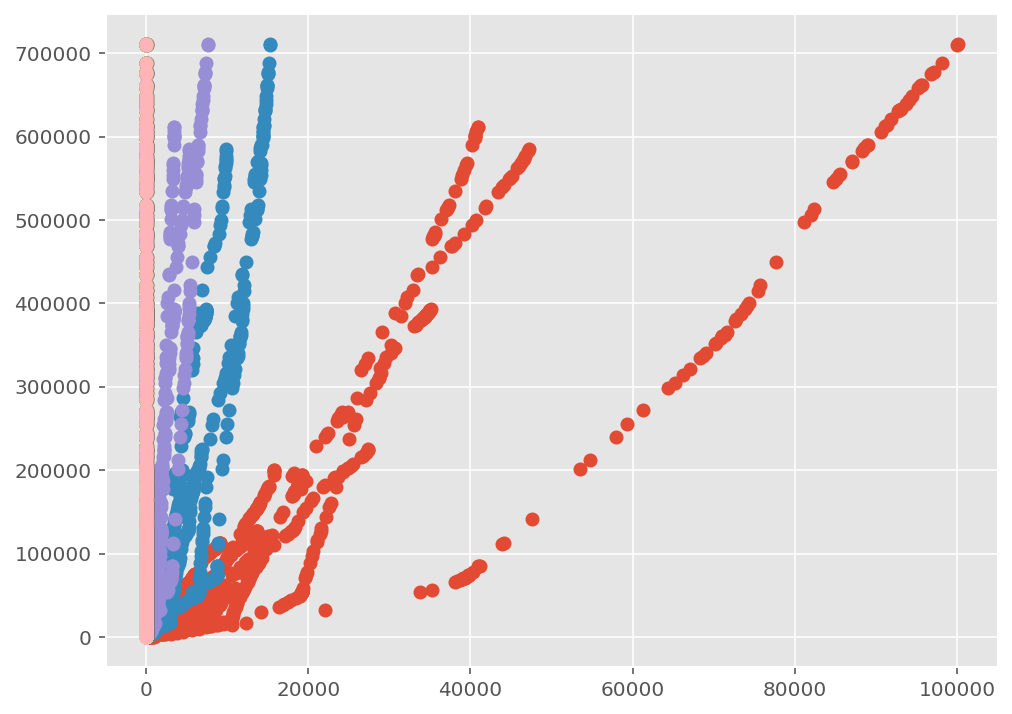

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))                                    # Ajuste del gráfico
ax.plot(X_test , y_test , 'o', label="Datos")                         # Ajuste para las etiquetas del gráfico
ax.plot(X_test, modelo.fittedvalues, 'r--.', label="Ajustado")           # Ajuste para las etiquetas del gráfico
legend = ax.legend(loc="best")                                           # Ajustes para las leyendas del gráfico
plt.xlabel('Cantidad de cajas')                                          # Etiqueta del eje X
plt.ylabel('Tiempo (min)')                                               # Etiqueta del eje Y
plt.title('Diagrama de dispersión con la recta del modelo ajustado');    # Título del gráfico
# fuente

In [ ]:
today_data=datos_demograficos[datos_demograficos.fecha==datos_demograficos.fecha.max()]

In [ ]:
today_data.head(1)

,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental,Vacunados_completos_%
525,2021-06-09,Andalucía,590632,47418,9872,5327,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5,7.2


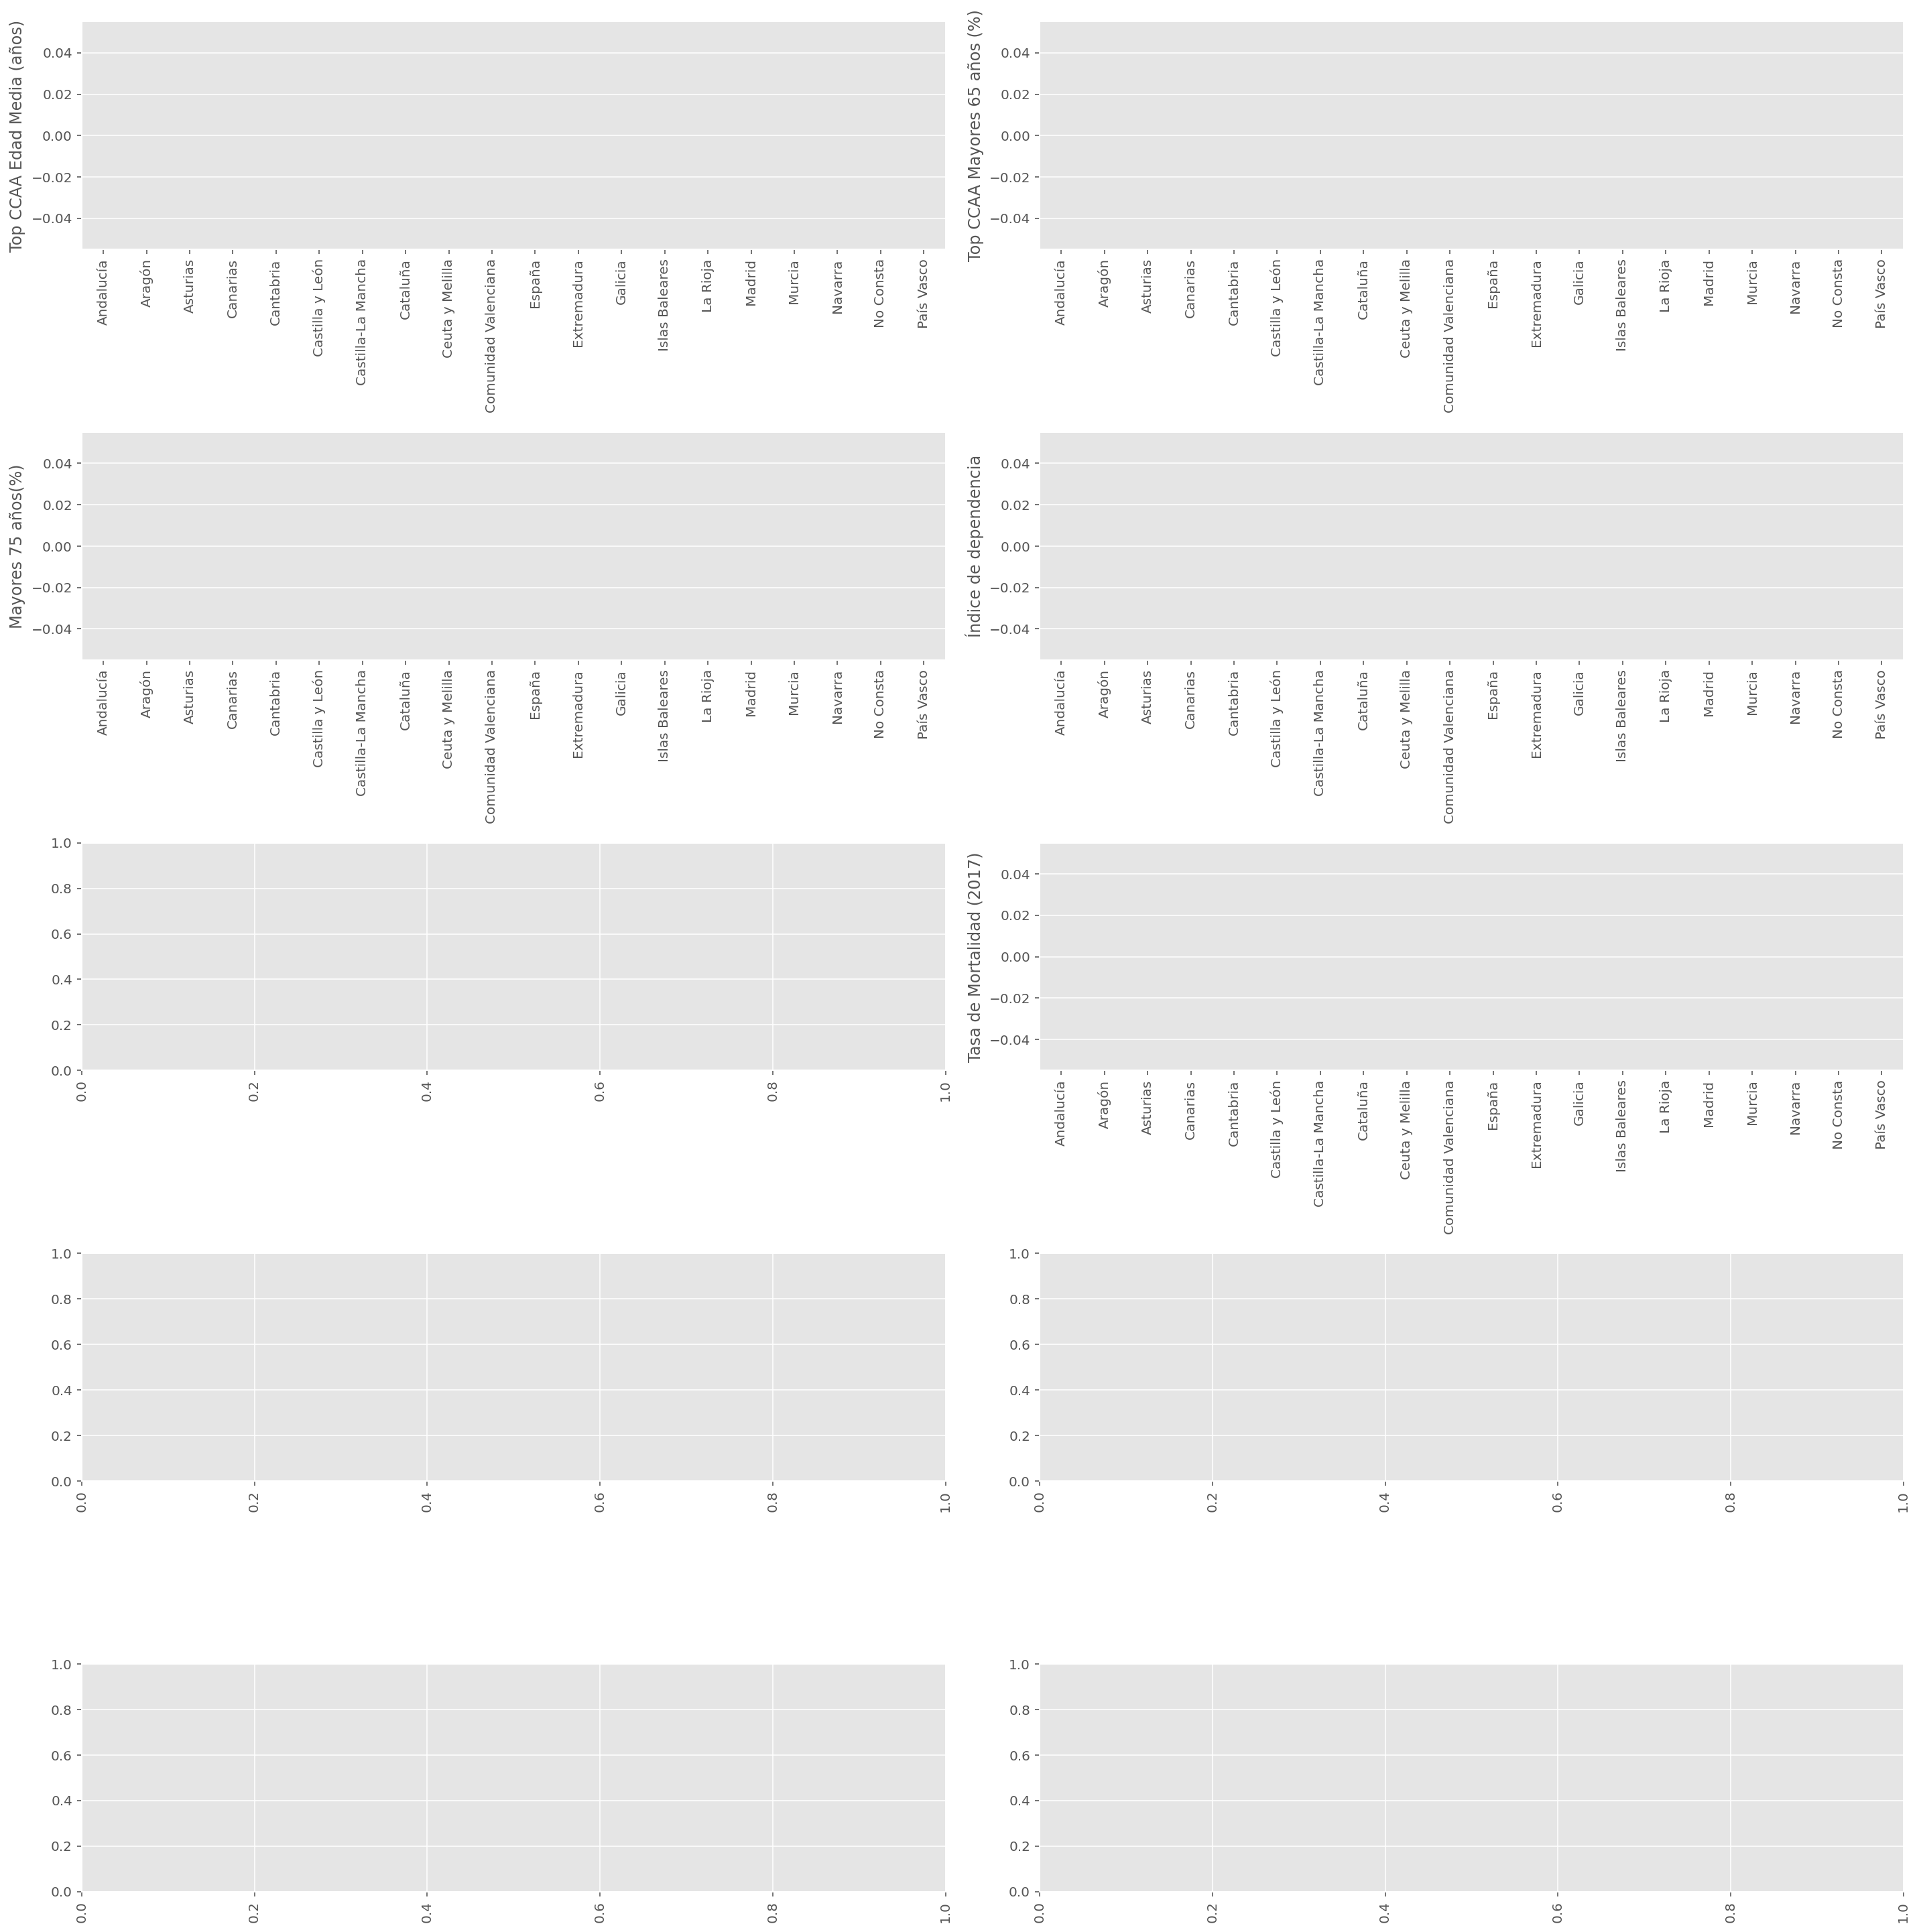

In [ ]:
today_data= today_data.loc[today_data.ccaa == 'España', :]
#today_data.drop(today_data.index[today_data.ccaa ])

#invoices.drop(invoices.index[invoices.price == 27.76], axis=0)

fig, axs = plt.subplots(5,2,figsize = (20,20))

# Edad Media (años)

top10_edadmedia = today_data[['ccaa','Edad Media (años)']].sort_values('Edad Media (años)', ascending = False).head(20)
plt1 = sns.barplot(x='ccaa', y='Edad Media (años)', data= top10_edadmedia, ax = axs[0,0])
plt1.set(xlabel = '', ylabel= 'Top CCAA Edad Media (años)')

# Pobrza extrema -top 10 de paises
top10_mayores65años = today_data[['ccaa','Mayores 65 años (%)']].sort_values('Mayores 65 años (%)', ascending = False).head(20)
plt1 = sns.barplot(x='ccaa', y='Mayores 65 años (%)', data= top10_mayores65años, ax = axs[0,1])
plt1.set(xlabel = '', ylabel= 'Top CCAA Mayores 65 años (%)')

# Esperanza de vida: paises con la esperanza mas baja
bottom10_mayores75años = today_data[['ccaa','Mayores 75 años(%)']].sort_values('Mayores 75 años(%)', ascending = False).head(20)
plt1 = sns.barplot(x='ccaa', y='Mayores 75 años(%)', data= bottom10_mayores75años, ax = axs[1,0])
plt1.set(xlabel = '', ylabel= 'Mayores 75 años(%)')

# Producto Interno Bruto PIB -últimos 10 paises
bottom10_indicedependencia = today_data[['ccaa','Índice de dependencia']].sort_values('Índice de dependencia', ascending = False).head(20)
plt1 = sns.barplot(x='ccaa', y='Índice de dependencia', data= bottom10_indicedependencia, ax = axs[1,1])
plt1.set(xlabel = '', ylabel= 'Índice de dependencia')

# Tasa de Mortalidad (2017)
bottom10_mortalidad2017 = today_data[['ccaa','Tasa de Mortalidad (2017)']].sort_values('Tasa de Mortalidad (2017)', ascending = False).head(20)
plt1 = sns.barplot(x='ccaa', y='Tasa de Mortalidad (2017)', data= bottom10_mortalidad2017, ax = axs[2,1])
plt1.set(xlabel = '', ylabel= 'Tasa de Mortalidad (2017)')


for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation = 90)
    
plt.tight_layout()
plt.savefig('eda')
plt.show()

In [ ]:
# comprobar tipo de relacion entre cada una de las variables --> mirar el ejemplo de la densidad

# DATOS SOCIALES

In [9]:
# DATOS SOCIALES
# ANALISIS DE LOS DATOS DEMOGRAFICOS

# selecciono las columnas que tocan
datos_sociales = df2[['fecha','ccaa','confirmados','hospitalizados','fallecidos','uci','tasa_pobreza','nivel_estudios','social'] ]
datos_sociales

datos_sociales_solos = df2[['tasa_pobreza','nivel_estudios','social'] ]
datos_sociales_solos

datos_sociales_solos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9468 entries, 0 to 9467
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tasa_pobreza    9468 non-null   float64
 1   nivel_estudios  9468 non-null   float64
 2   social          9468 non-null   float64
dtypes: float64(3)
memory usage: 295.9 KB


In [11]:
datos_sociales_solos.describe().T

,count,mean,std,min,25%,50%,75%,max
tasa_pobreza,9468.0,21.083333,8.624018,8.6,14.20,17.70,29.90,37.60
nivel_estudios,9468.0,40.083333,7.734191,27.7,33.20,40.25,46.90,55.00
social,9468.0,48.635556,5.605870,35.3,43.72,49.85,52.08,57.58


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f222bbdea90>,
      dtype=object)

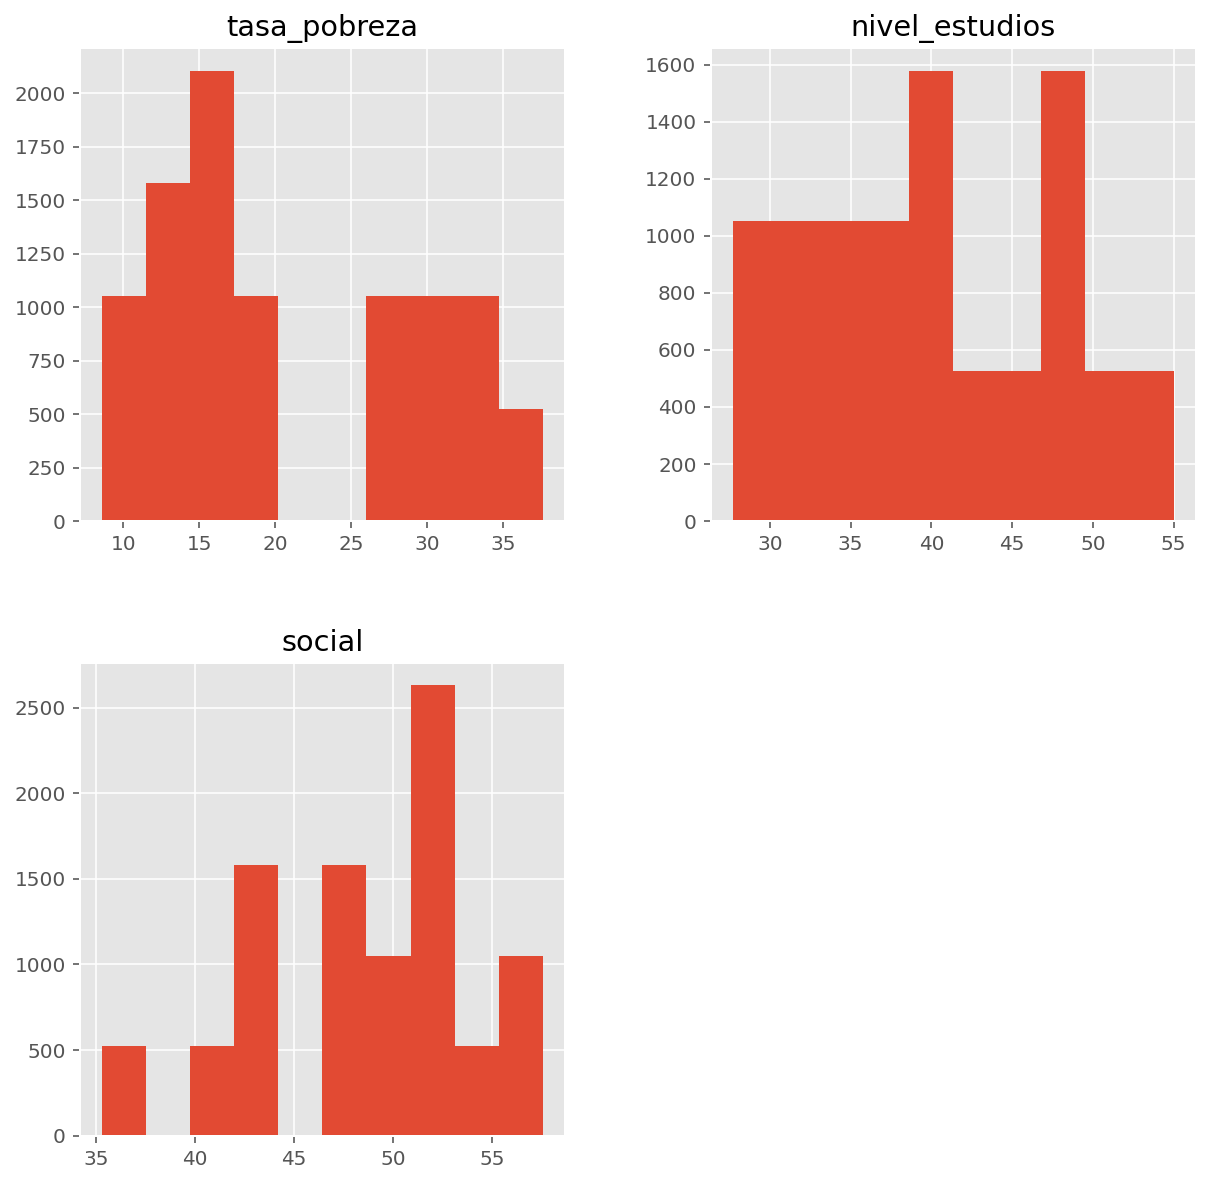

In [14]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
datos_sociales_solos.hist(ax = ax)

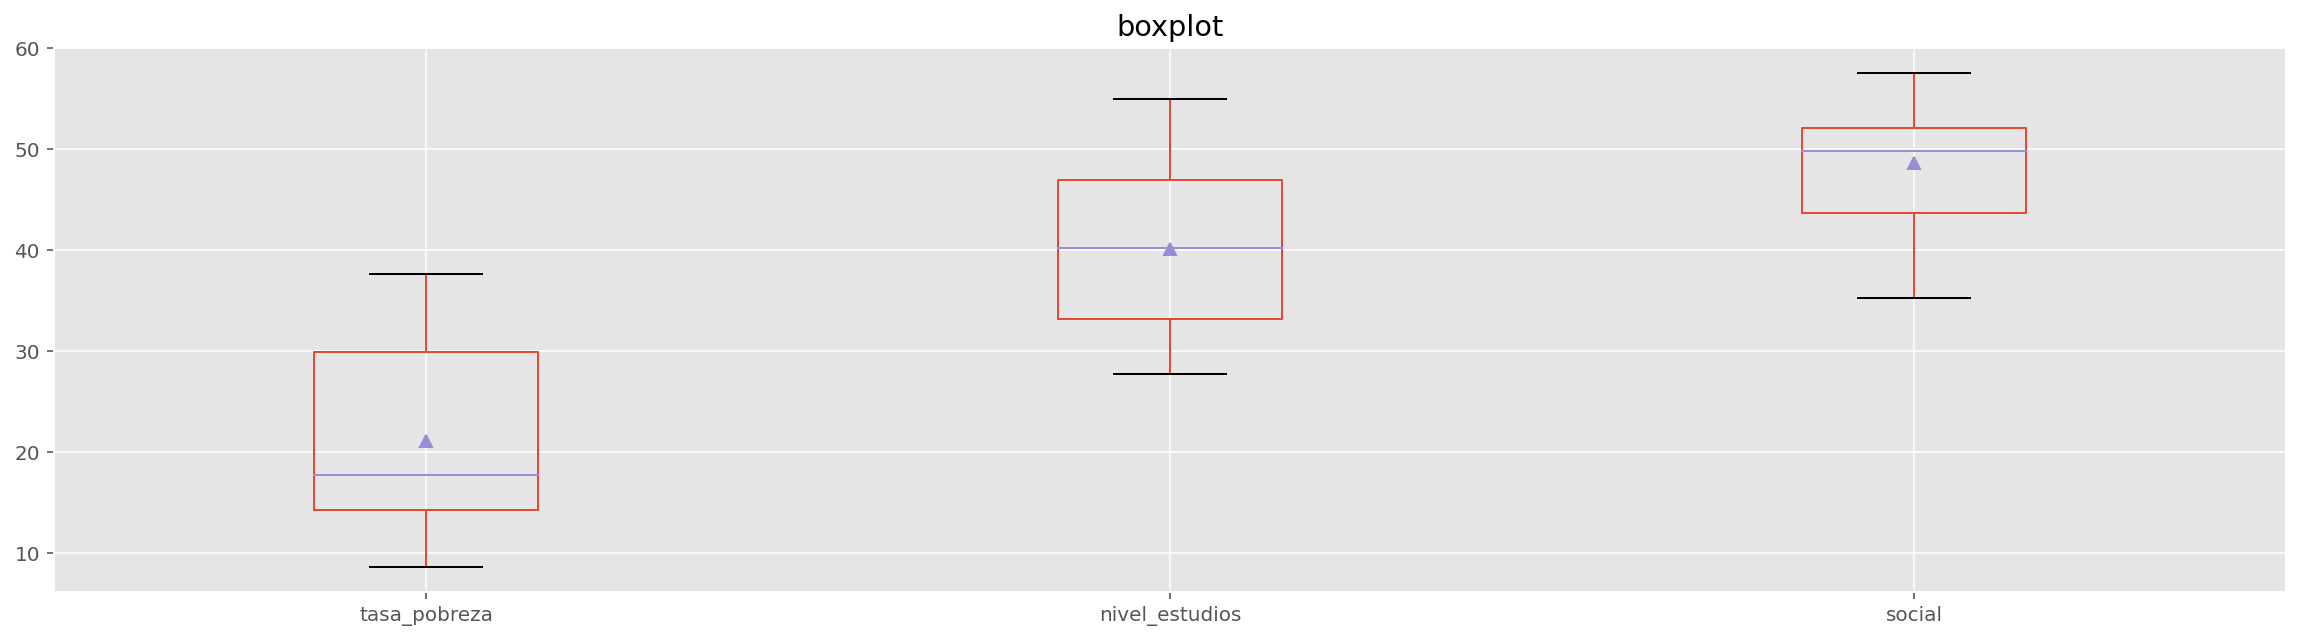

In [16]:
ax= datos_sociales_solos.plot(kind='box', title='boxplot', showmeans=True, figsize=(20, 5))
plt.show()